In [ ]:
import os
try:
    from google.colab import drive
    COLAB = True
    print("Estoy en Google CoLab")
    %tensorflow_version 2.x
    !pip install livelossplot
except:
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    print("No estoy en Google CoLab")
    COLAB = False

Estoy en Google CoLab
     |████████████████████████████████| 793 kB 5.9 MB/s 
     |████████████████████████████████| 381 kB 43.4 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.


In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

# Visualizando el aprendizaje de CNN

In [ ]:
import tensorflow.keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K

import os
import urllib
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


## Visualizando el Aprendizaje de Redes Convolucionales

Actualmente existe un problema en el mundo de la redes convolucionales que no está siendo fácil de solucionar. El problema estriba en la opasidad de la redes convolucionales. Es por esta opasidad por lo que a menudo se dice que los modelos DL son *cajas negras*. Dicho de otra forma, no es fácil **interpretar** como usa la red las características aprendidas para llevar a cabo la tarea para la que ha sido entrenada. 

Esta dificultad a la hora de interpretar lo que un modelo ha aprendido tiene varios incovenientes. En ciertas áreas la interpretabilidad del modelo es muy importante. Un ejemplo claro de esta problematica se da en las aplicaciones médicas. En este tipo de aplicaciones es sumamente importante no solo tener un modelo eficiente, sino también saber el porqué de la respuesta, ya que las consecuencias de un error pueden ser sumamente graves, y tener un sistema opaco tomando dichas decisiones cuanto menos causa desconfianza. 

En esta línea la Comisión Europea en 2018 publicó una comunicación en la enfatizaba la importancia de la interpretabilidad en la investigación en inteligencia artificial especialmente para facilitar la confianza de las personas en dichos sistemas: "*Los sistemas basados en inteligencia artificial deberían ser diseñados y desarrollados de manera que permita a los humanos comprender en que se basan sus decisiones con el fin de incrementar la transparencia y reducir el* **riesgos de error por sesgo**". Un ejemplo que genera gran desconfianza debido a los posibles errores por sesgo racial son las aplicaciones judiciales.

Por otro lado, el tener una idea de como la red esta funcionando, puede ayudar a los desarroladores a determinar porqué la red se equivoca en ciertas muestras e incluso hacerla resistente a ataques que buscan el comportamiento erróneo de la red. 

Aunque los modelos DL son *cajas negras* gracias a las representaciones jerárquicas aprendidas facilita enormemente poder dar una interpretación visual a lo que las diversas capas convolucionales han aprendido.  Desde 2013 se han generado muchas técnicas para visualizar e interpretar estas representaciones e intentaremos cubrir algunas de las más representativas y accesibles. Concretamente, en este notebook vamos a ver cómo:

1. Visualizar las salidas de las capas intermedias (**activaciones intermedias**): útil para comprender cómo las sucesivas capas transformarn sus entradas y para tener una idea inicial de la funcionalidad que tienen los filtros convolucionales individuales.
2. Visualizar filtros convolucionales: útil para entender de forma precisa a qué patrones visuales (o conceptos) son sensibles los diversos filtros.
3. Visualizar **mapas de calor** de las clases de activación sobre muestras (imágenes): útil para entender qué partes de una imagen son identificadas como una clase específica de las reconocidas por la red, lo que, por ejemplo, puede servir además para localizar objetos reconocidos dentro de una imagen.


En este tema vamos a ver diferentes métodos de visualización. Para el primer método usaremos la pequeña red que entrenamos desde cero para reconocer gatos y perros. Para los otros dos métodos usaremos el modelo VGG16 que viene preentrenado y que ya hemos usado anteriormente.

## Visualizando Activaciones Intermedias (feature maps)

Visualizar las activaciones intermedias consiste en mostrar el mapa de características que conforman las salidas de las diferentes capas de convolución y pooling de la red para una determinada entrada (la salida de una capa a menudo se llama su **activación**, por ser la salida de su función de activación). 

Este procedimiento da una visión sobre cómo una entrada es descompuesta por las distintas capas aprendidas por la red, y no solo se puede hacer con redes convolucionales sino con cualquier tipo de capa, aunque sea en estas redes donde la interpretación visual es más directa. En este caso, los mapas de características tienen 3 dimensiones: anchura, altura y profundidad (canales). Cada canal codifica características relativamente independientes, por lo que la forma más apropiada de visualizar estas características es también representar independientemente los contenidos de cada canal como imágenes 2D. 

Para ponerlo en práctica, comencemos cargando un modelo entrenado para reconocer perro y gatos:

In [ ]:

if not os.path.exists('cats_and_dogs_DA.h5'):
    model_url = 'https://hdvirtual.us.es/discovirt/index.php/s/LrmfAGx24tcYqsG/download'
    urllib.request.urlretrieve(model_url, 'cats_and_dogs_DA.h5')

model = load_model('cats_and_dogs_DA.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

In [ ]:
model.input

<KerasTensor: shape=(None, 50, 50, 3) dtype=float32 (created by layer 'conv2d_4_input')>

Vamos a cargar una imagen de prueba (para que no haya correlación con el aprendizaje llevado a cabo, esta imagen será parte de nuestro conjunto de test):

In [ ]:
url_img = 'https://hdvirtual.us.es/discovirt/index.php/s/pNmfDgkEEN9M3cN/download'
urllib.request.urlretrieve(url_img, 'dog.1820.jpg')
img_path = 'dog.1820.jpg'

# Vamos a convertir la imagen en un tensor apropiado
img = image.load_img(img_path, target_size=(50, 50))
print('Image size', img.size)
img_tensor = image.img_to_array(img)
print('Tensor shape', img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Recordemos que el modelo fue entrenado con entradas normaizadas:
img_tensor /= 255.

# La forma ahora es (1, 150, 150, 3)
print('Expanded tensor shape', img_tensor.shape)

Image size (50, 50)
Tensor shape (50, 50, 3)
Expanded tensor shape (1, 50, 50, 3)


Usando la función adecuada de `matplotlib` podemos mostrarla:

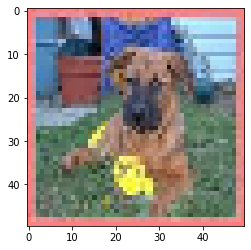

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

Hemos de tener en cuenta que Keras solo trabaja con modelos, y la información que estamos buscando son las activaciones internas de un modelo ya definido, que el propio no proporciona externamente. Por ello, y con el fin de extraer los mapas de características, vamos a crear un modelo adicional de Keras que toma batches de imágenes como entrada y devuelve las activaciones de todas las capas de convolución y pooling del modelo anteriormente entrenado.

Para ello, usaremos la api de Keras. Esto nos permitirá trabajar con múltiples salidas. 

In [ ]:
model.layers[3].output

<KerasTensor: shape=(None, 11, 11, 64) dtype=float32 (created by layer 'max_pooling2d_5')>

In [ ]:

# Extrae las salidas de las 8 capas superiores:
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
# Crea un modelo que devuelva estas salidas a partir de la entrada:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Cuando a este modelo se le pasa una imagen de entrada, devuelve los valores de las activaciones de las 8 primeras capas del modelo original. 


Por ejemplo, la activación de la primera capa convolucional sobre nuestra imagen, sería:


In [ ]:
activations = activation_model.predict(np.array([img_tensor[0]/255]))

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 48, 48, 32)


Un mapa de características de tamaño 148 x 148 con 32 canales. Visualicemos algunos de ellos por medio de las funciones de `matplotlib`:


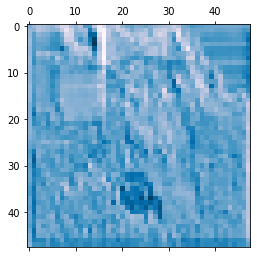

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='PuBu_r')
plt.show()

Por ejemplo, el 6º canal sería:


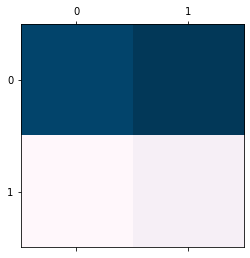

In [ ]:
first_layer_activation = activations[3]
plt.matshow(first_layer_activation[0, :, :, 7], cmap='PuBu_r')
plt.show()

In [ ]:
len(activations)

4

Si modificas el valor de la capa a la que accedes podrás observar las diferencias existentes entre los fitros aprendidos conforme se profundiza en la red.

Podemos mostrar una visualización completa de todas las activaciones de la red:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


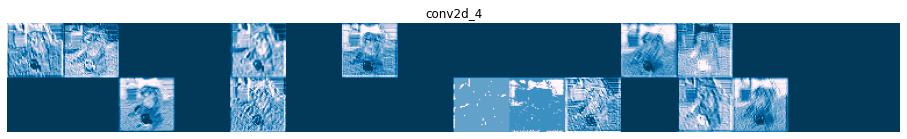

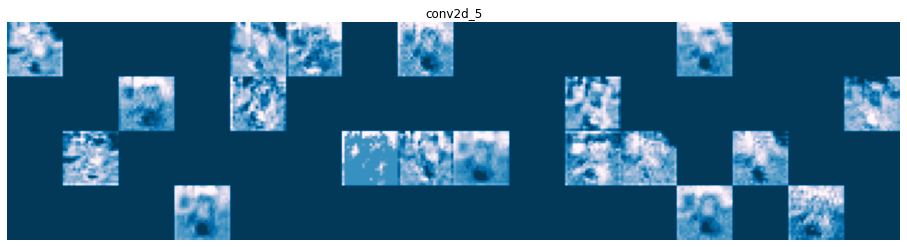

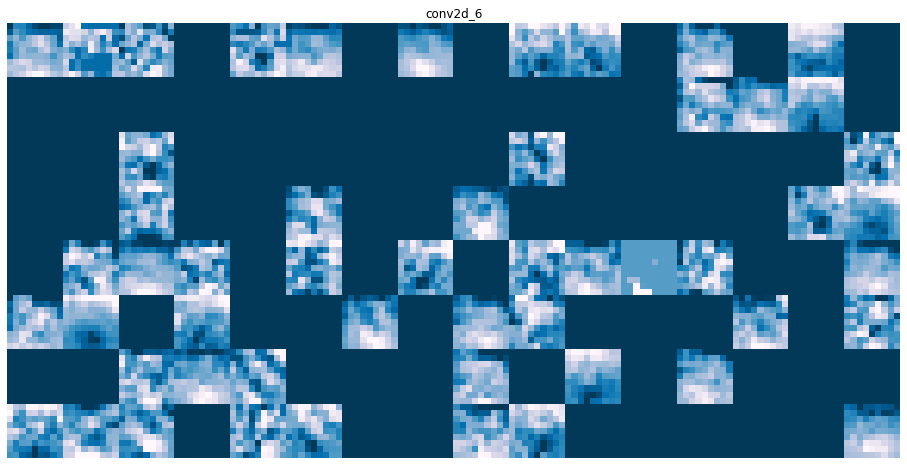

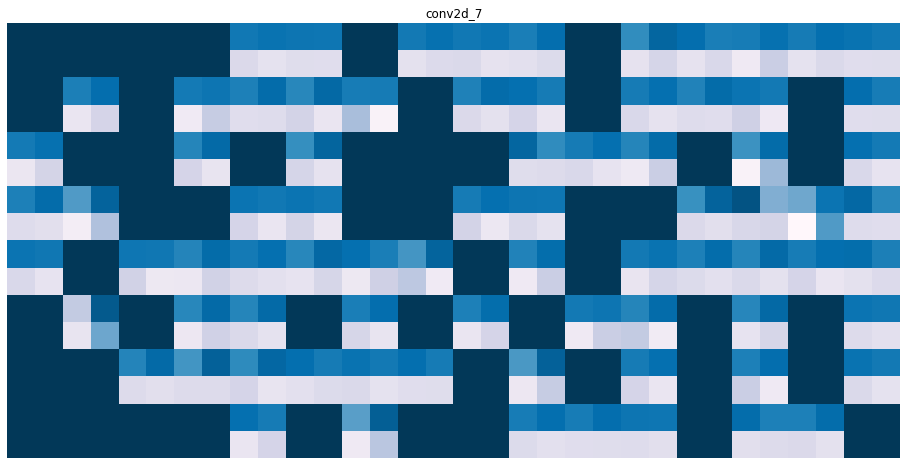

In [ ]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):

    # The feature map has shape (1, size, size, n_features)
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='PuBu_r')
    
plt.show()

Alagunas cosas que debemos enfatizar:

* La primera capa actúa como una colección de detectores de bordes, y las activaciones prácticamente almacenan toda la información presente en la imagen incial.
* A medida que profundizamos en la red, las activaciones se van haciendo más abstractas y menos interpretables visualmente. Empiezan a codificar conceptos de mayor nivel y menos información visual, más relacionados con la clase a la que pertenece la imagen.
* Las activaciones se hacen más dispersas cuando la profundidad de la capa aumenta: en la primera capa todos los filtros se activan, pero en capas más profundas algunos filtros están en blanco. Esto significa que esos filtros codifican patrones que no están presentes en la imagen de entrada.

De esta forma, una red DL actúa efectivamente como un proceso de **destilación de información**, en el que la información relevante va perdiendo importancia para destacar los conceptos clave que determinan la clasificación. Es análogo a la forma en que los animales percibimos el mundo: tras unos segundos de observar una escena, recordamos información abstracta de los objetos que la componen, pero no podemos recordar detalles específicos de los mismos.

## Visualizando Filtros Convolucionales


<img src='https://hdvirtual.us.es/discovirt/index.php/s/Za72Qpbr7GJ7T2k/preview' />

Visualizar patrones aprendidos (feature visualization) consiste en mostrar que entrada produce un alto impacto en alguna parte de la red. Ya hemos visto que las redes neuronales son **funciones diferenciables**. Si queremos encontrar que entrada produce cierto comportamiento sólo tenemos que establecer el objetivo y iterar sobre este objetivo usando los gradientes para actualizar aquellos elementos que influyen en dicho objetivo. En este caso, iremos actualizando la entrada a la red, empezando con una imagen aleatoria ruidosa:

<img src='https://hdvirtual.us.es/discovirt/index.php/s/nPCfqaP9x9LxriB/preview' />

A este método se le conoce como **gradiente descendente en el espacio de entrada**. Dependiendo de nuestros intereses podemos establecer diferentes objetivos:

<img src='https://hdvirtual.us.es/discovirt/index.php/s/T8qTWj4e54ZxQTf/preview' width='75%' />

Si nos interesa patrones individuales, tendremos que buscar que imágenes generan un **activación** importante en una neurona o un canal determinado (recordamos en cada canal extrae patrones *independientes* de los otros). 

![deconvolution](https://hdvirtual.us.es/discovirt/index.php/s/mowctNfQYoB48iX/preview)

Si queremos entender una capa como un todo, podemos usar el objetivo usado en DeepDream y encontrar que imágenes le *resultan interesantes a la capa*.

Y si queremos generar imágenes con una gran activación en una determinada categoría tenemos dos opciones. Usar la entradas de la **softmax** o la salida de ésta (las probabilidades). La entradas a la softmax se puede ver como la evidencia para cada clase y las probabilidades como la esperanza de cada clase según las evidencias. Usar la salida de las probablidades tiene un incoveniente. Una forma sencilla de incrementar la probabilidad de una clase es decrementar la evidencia de las otras. Normalmente, optimizar la entradas a la softmax genera imágenes de mayor calidad.

Estos son sólo algunos de los objetivos que se pueden establecer, pero se pueden intentar muchos otros. Por ejemplo en transfencia de estilo (el último tema de esta asignatura) se usan objetivos para capturar el estilo y el contenido de una imagen.

### Gradiente descendente en el espacio de entrada

El proceso es simple (teniendo las herramientas adecuadas): construimos una función de pérdida que maximiza el valor de un filtro determinado de una capa convolucional, comenzamos con una entrada cualquier (normalmente, en blanco o grises), y usamos un SGD para ajustar los valores de la imagen con el fin de maximizar sus valores de activación.

Vamos a trabajar ahora directamente con la VGG16. Por ejemplo, el siguiente código muestra cómo definir una función de pérdida adecuada para el filtro 0 de la capa "block3_conv1" de la red VGG16 pre-entrenada con ImageNet:

In [ ]:
model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Vamos a crearnos un modelo intermedio para poder extraer ese filtro:

In [ ]:
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

Para implementar el descenso del gradiente necesitamos calcular el gradiente de la función de coste respecto a las entradas del modelo. Crearemos una la función de coste primero.

In [ ]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    
    # se eliminan los bordes para mejor visualización
    
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

También necesitaremos una función para llevar a cabo el gradiente **ascendente*. 

Con el fin de asegurar que la magnitud de las actualizaciones se mantengan en un rango adecuado, normalizaremos el gradiente (dividiéndolo por la norma L2 y sumando una pequeña cantidad fija para que no haya problemas de división por 0).


In [ ]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate, compute_loss):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    
    # calculamos los gradientes para que la imagen produzca el menor
    # error posible en nuestro filtro
    grads = tape.gradient(loss, img)
    
    # Normalizamos los gradientes
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


Una vez construido todo lo anterior, bastaría hacer un bucle para hacer el SGD de forma efectiva:


In [ ]:
# Empezamos con una imagen gris ruidosa.
input_img_data = np.random.random((1, 150, 150, 3)) * 0.5

# Ejecutamos el gradiente ascendente 40 iteraciones
learning_rate = 0.6
for i in range(500):
    # Obtenemos el error (la activación) y el gradiente
    loss_value, input_img_data = gradient_ascent_step(input_img_data, filter_index, learning_rate, compute_loss)
    print(loss_value.numpy())
    
input_img_data = input_img_data.numpy()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


El resultado es un tensor de imagen (en valores flotantes) de tamaño `(1, 150, 150, 3)`, por lo que hemos de post-procesarlo para convertirlo en valores enteros en  [0, 255] y poder mostrarlo. Vamos a crear una función que haga precisamente eso:


In [ ]:
def deprocess_image(x):
    # normalizamos el tensor: centrado en 0. y con std 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # desplazamos 0.5 para hacerlos positivos y eliminamos lo que este fuera del rango [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convertimos a RGB
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

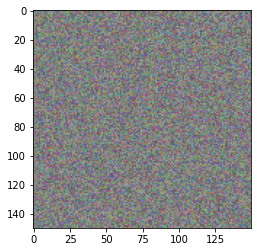

In [ ]:
im = deprocess_image(input_img_data)
plt.imshow(im[0])

Ahora que tenemos todas las piezas podemos ponerlas juntas en una sola función que toma como entrada el nombre de una capa y un índice de filtro, y devuelve un tensor de imagen que representa el patrón que maximiza la activación de ese filtro:


In [ ]:
from random import randint
def generate_pattern(layer_name, filter_index, size=150, steps=40, jitter_jump=0, 
                     return_steps=False, lr=1.):
    
    
    layer = model.get_layer(name=layer_name)
    feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)
    
    def _compute_loss(input_image, filter_index):
        activation = feature_extractor(input_image)
        # We avoid border artifacts by only involving non-border pixels in the loss.
        filter_activation = activation[:, 2:-2, 2:-2, filter_index]
        return tf.reduce_mean(filter_activation)

    ph_size = size + int(0.2 * size)
    input_img_data =  np.random.random((1, ph_size, ph_size, 3)) * 0.5
    

    # Ejecutamos el gradiente ascendente
    lr = 1.
    x, y = int((ph_size - size) / 2), int((ph_size - size) / 2)
    ax = None
    images = []
    for i in range(steps):
        xjump, yjump = randint(-jitter_jump, jitter_jump), randint(-jitter_jump, jitter_jump)
        x, y = min(ph_size - size, max(0, x - xjump)), min(ph_size - size, max(0, y - yjump))
        
        im = input_img_data[:, x:x+size, y:y+size, :]
        
        
        # Obtenemos el error (la activación) y el gradiente
        loss_value, im = gradient_ascent_step(im, filter_index, lr, _compute_loss)
        
        input_img_data[:, x:x+size, y:y+size, :] = im
        
        if return_steps:
            arr = np.copy(input_img_data[0][x:x+size, y:y+size])
            images.append(deprocess_image(arr))

        
    img = input_img_data[0][x:x+size, y:y+size]
    if return_steps:
        images.append(deprocess_image(img))
        return images
    else:
        return deprocess_image(img)



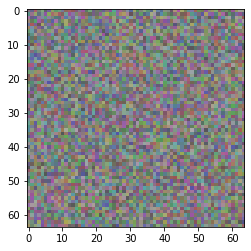

In [ ]:
img = generate_pattern('block3_conv1', 0, 64, jitter_jump=2, 
                         steps=500, return_steps=False, lr=0.5)
plt.imshow(img)

In [ ]:
images = generate_pattern('block5_conv1', 0, 64, jitter_jump=2, steps=500, return_steps=True)

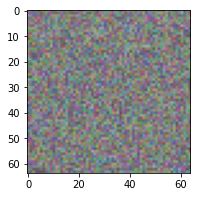

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(images[0])

def _init():
    im.set_data(images[0])
    return (im, )


def _animate(i):
    im.set_data(images[(i+1)%len(images)])
    return (im, )

anim = animation.FuncAnimation(fig, _animate, init_func=_init,
                               frames=len(images), interval=100, blit=True)
HTML(anim.to_html5_video())


Lo interesante es que podemos visualizar todos los fitros de cada capa. En el ejemplo siguiente se muestra cómo obtener una visualización de los 64 primeros filtros de cada capa convolucional de los primeros 4 bloques, y los mostramos como una malla de 8x8 patrones:


In [ ]:
for layer_name in ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1']:
                   #'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2',
                   #'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
    results += 255

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size, steps=100, jitter_jump=1)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results/255)
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Estas visualizaciones dan mucha información acerca de cómo las capas convolucionales ven el mundo, de forma similar a cómo la transformada de Fourier descompone las señales como una colección de funciones coseno. Observa cómo el patrón de los filtros se vuelve más complejo a medida que se profundiza en la red.

## Saliency Maps

Si nos muestran una imagen de un gato y nos piden que la clasifiquemos rápidamente responderemos: Gato!. Pero una red podría no ser tan lista como tú. Ella podría clasificarla como un gato, un león o como la profesora McGonagall (Harry Potter). Este comportamiento errático se puede deber a diversas razones: sesgo en los datos de entrenamiento, falta de regularización o demasiadas películas de Harry Potter vistas por la red. 

¿No nos gustaría saber en que se basa la red para dar una cierta respuesta? Hay una forma de medir la zona en la que se apoya la red para llevar a cabo la clasificación. Más formalmente:

**Dada una imagen I, una case C, y la clasificación de una red con una función de score S, nos gustaría poderar la importancia de los píxeles de I basados en el score S(I) para la clase C.**

O menos formalmante es equivalente a decir que queremos encontrar que pixeles son responsables para que red de como más probable la clase C al pasar la imagen I por ésta. 

Sabemos que dada una función $f(x, y, z)$, podemos encontrar el impacto de las variables$x$, $y$, $z$ en un punto específico $(x0, y0, z0)$ usando sus derivadas parciales. En nuestro caso, esas variables son los píxeles, por lo si tenemos una función de scoring S sobre una clase C, podemos podemos calcular las derivadas parciales por cada pixel. Esto puede parecer muy complejo, pero ya lo hemos hecho en el ejempo anterior en la función `iterate`. En esta ocasión no vamos a crear dicha iteración, ya que no vamos actualizar la imagen de entrada pero el resto del código es muy similar.

Vamos a usar la red vgg16 como anteriormente, pero esta vez no quitaremos las capas totalmente conectadas (densas):


In [ ]:
K.clear_session()

# Observa que ahora sí incluimos la última capa densa clasificadora;
# en todos los casos previos la descartamos.
model = VGG16(weights='imagenet')
model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Como imagen de entrada vamos a usar varias imágenes con objetos que son parte de la clasificación de ImageNet.

In [ ]:
def show_images(*args, tags=None):
    n = len(args[0])
    plt.figure(figsize=(20, 4*len(args)))
    for i in range(n):
        for j in range(len(args)):
            data = args[j][i]
            img = data['image']
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            cmap = None if 'cmap' not in data else data['cmap']
            
            if len(img.shape) == 3 and img.shape[2] == 1:
                ax.imshow(img.reshape(img.shape[:2]), cmap=cmap)
            else:
                ax.imshow(img, cmap=cmap)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            if 'tag' in data:
                tags = data['tag']
                n_lines = len(tags.split('\n'))
                ax.text(0.0,-0.1 * n_lines, tags, size=12, 
                        ha="left", transform=ax.transAxes)

    plt.show()

49152/35363 [=========================================] - 0s 0us/step


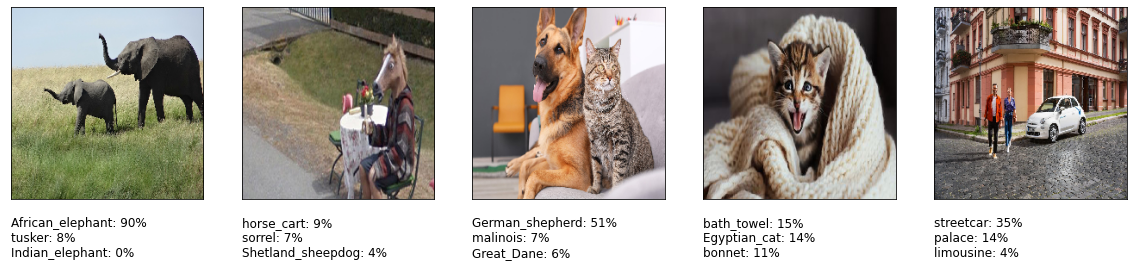

In [ ]:
urls = ['https://hdvirtual.us.es/discovirt/index.php/s/NWboNQ94dmFJcxn/download', 
        'https://hdvirtual.us.es/discovirt/index.php/s/y53yDBZTBDcRSfH/download',
        'https://hdvirtual.us.es/discovirt/index.php/s/nDfkmx2xs7zGCBM/download',
        'https://hdvirtual.us.es/discovirt/index.php/s/jjJrdA2cS7xT3yQ/download',
        'https://hdvirtual.us.es/discovirt/index.php/s/YwWT4E9kDHf25RH/download']
batch = []
raw_images = []
for i, url in enumerate(urls):
    file_name = f'img{i}.jpg'
    # Descargamos la imagen
    urllib.request.urlretrieve(url, file_name)
    
    # La leemos con un tamaño 224 x 224 (según la entrada de la red)
    img = image.load_img(file_name, target_size=(224, 224))
    
    # Convertimos en un array de numpy
    x = image.img_to_array(img)
    
    raw_images.append(np.copy(x)/255)

    # y finalmente preprocesamos
    x = preprocess_input(x)
    
    # la agregamos a nuestro batch
    batch.append(x)

batch = np.array(batch)
preds = model.predict(batch)
texts = ['\n'.join([f"{name}: {int(score*100)}%" for _, name, score in dpred])
                    for dpred in decode_predictions(preds, top=3)]

images = [{'image': im, 'tag': tag} for im, tag in zip(raw_images, texts)]
show_images(images)    

En el caso de los elfantes, las tres clases principales son:

* Elefante Africano (con un 90.9% de probabilidad)
* Tusker (elefante) (con un 8.6% de probabilidad)
* Elefante Indio (con un 0.4% de probabilidad)

La red reconoce a elefante africano como la clase más probable.

Vamos a necesitar acceder a las entradas de la `softmax`. Para ello debemos hacer un pepueña modificación en la red: anular dicha función de activación. La siguiente función es una función de utilidad, tomada de *keras-vis* que nos permite hacer dicha alteración:

In [ ]:
import os 
import tempfile
from keras.models import load_model
def apply_modifications(model, custom_objects=None):
    """
    Aplicamos las modificaciones realizadas en el modelo creando un nuevo grafo de
    computación. Para poder modificar el grafo tenemos que grabar y leer el modelo.
    """
    model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(model_path)
        return load_model(model_path, custom_objects=custom_objects)
    finally:
        os.remove(model_path)


Desactivamos la activación asignándole una activación lineal y aplicamos el cambio:

In [ ]:
model.layers[-1].activation = keras.activations.linear
linear_model = apply_modifications(model)

Como función de *loss* usaremos la entrada a la softmax, las envidencias que ahora son la salida de la capa de predicciones:

In [ ]:
def get_saliency_map(model, image, class_idx):
    im = tf.convert_to_tensor(np.array([image]))
    with tf.GradientTape() as tape:
        tape.watch(im)
        predictions = model(im)
        loss = predictions[:, class_idx]
    
    # obtenemos los gradientes respecto a la imagen de entrada
    gradient = tape.gradient(loss, im)
    
    # maximo desde los canales
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convertimos a numpy
    gradient = gradient.numpy()
    
    # normalizamos entre 0 y 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())
    
    return smap


Por último, para obtener una mejor visualización, escalamos y obtenemos el máximo de cada canal (R,G,B):

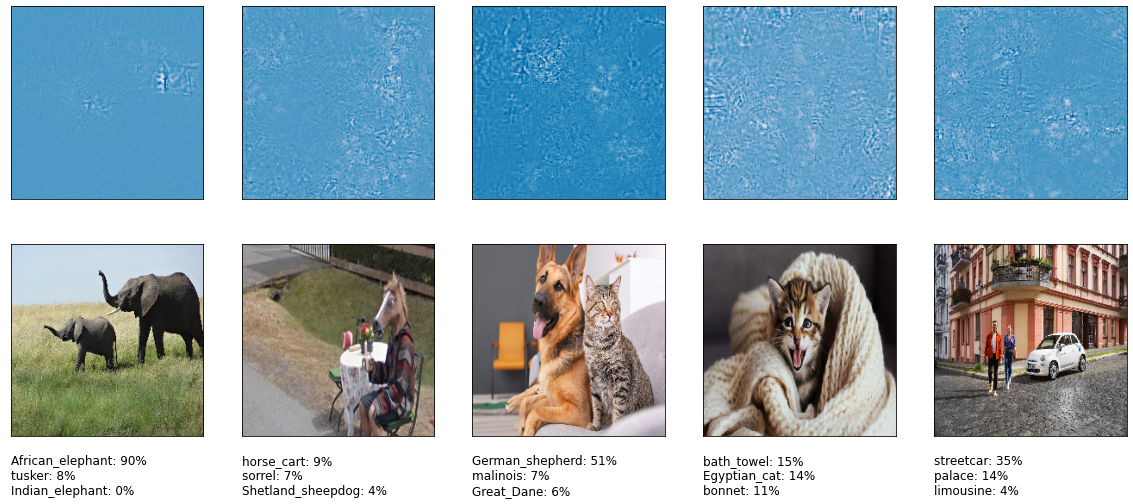

In [ ]:
grads = [{'image': get_saliency_map(linear_model, im, p.argmax())[0], 
          'cmap': 'PuBu_r'} 
         for (im, p) in zip(batch, preds)]
show_images(*[grads, images])

Como vemos, los píxeles más importantes, según el saliency map, son los correspondientes a la localización de los objetos pero sin embargo hay mucho ruido.



## Global Average Pooling (GAP)

Una estructura muy común en DL para clasifación de imágenes es la compuesta por un conjunto de capas convolucionales y/o max-pooling seguidas de varias capas totalmente conectadas. Las capas convolucionales serás las encargadas de aprender a extraer características. Las capas totalmente conectadas usará los mapas de características activados para llevar a cabo la clasificación. Esta estructura se ve por ejemplo en la VGG16:

<img src="https://hdvirtual.us.es/discovirt/index.php/s/RSnByRydDnLs6j4/preview" alt="vgg16" width="50%"/>

Una opción para eliminar las capas totalmente conectadas es usar una capa GAP (Global Average Pooling). 

<img src="https://hdvirtual.us.es/discovirt/index.php/s/Yr5geg8WaSEJ6Bk/preview" alt="gap" width="50%"/>

Esta capa únicamente tomará el valor medio por cada mapa de característica de la última capa convolucional como podemos ver en la implemetanción de esta capa en Keras:

```
class GlobalAveragePooling2D(_GlobalPooling2D):

    def call(self, inputs):
        if self.data_format == 'channels_last':
            return K.mean(inputs, axis=[1, 2])
        else:
            return K.mean(inputs, axis=[2, 3])
```


### Visualizando Mapas de Calor de las Activaciones de cada Clase

En el primer artículo ([Network In Network](https://arxiv.org/pdf/1312.4400.pdf)) que propuso el uso de las GAP fueron un poco extremistas y la salida de la GAP (las medias de cada mapa carásterísticas) la introdujeron directamente en la capa capa *softmax* para llevar a cabo la clasificación. De esta forma, la última capa que genera mapas de características debería tener una dimensión igual al número de categorías a clasificar. Al pasar la media directamente por la *softmax* obligaban a que cada mapa asociado a una clase concreta fueran *coherentes* con su categoría. 

Esto entre otros beneficios que veremos más adelante permitía visualizar los mapas y ver la activación de estos coherentes a la categoría detectada:

<img src="https://hdvirtual.us.es/discovirt/index.php/s/Kwy7eAwnx8KSrLc/preview" alt="feature_map_vis" width="75%"/>

Se observa que el mapa más activo correspondiente a su categoría, pero además la parte más activa del mapa se corresponde con el elemento a clasificar dentro de la imagen. Por tanto, no solo se está haciendo una clasificación, sino también una **detección** del elemento dentro de la imagen. Otro aspecto importante, es que mediante esta técnica podemos comprobar si la red está *mirando* al lugar correcto para clasificar. A estos mapas se les conoce como mapas de activación de clases (en inglés CAM - Class Activation Map).

Como hemos comentado este enfoque era un poco extremista. En vez de directamente pasar la salida de la GAP a la *softmax* podemos colocar una capa final densa. Así se obliga al entrenamiento a poderar la importancia de cada mapa de características para llevar a cabo la detección de una clase en cuestión. Además, con esta técnica la dimensión de la salida de la GAP puede ser más flexible y tener más mapas de características.

Por ejemplo, en la imagen siguiente $w_1$ determina como de importante es el primer mapa de caraterísticas para llevar detectar la clase  *Australian terrier*. 

<img src="https://hdvirtual.us.es/discovirt/index.php/s/nzSXkCG4rAMRHJR/preview" alt="gap_working" width="50%"/>

El número total de pesos a aprender será el tamaño de la última capa de convolución multiplicando por el número de clases de la tarea en cuestión. Vamos a ver estas cuentas usando la red ResNet50 pre-entrenada para clasificar ImageNet (1000 clases) que usa la GAP como acabamos de explicar. Con las siguiente líneas de código obtenemos un resumen en texto plano de la estructura de la red, incluido el número parámetros por capa:

```
from keras.applications.resnet50 import ResNet50

ResNet50().summary()
```

<img src="https://hdvirtual.us.es/discovirt/index.php/s/dtta6QQcRWSw9C3/preview" alt="resnet50_keras" width="50%"/>

En la imagen se muestra solamente las últimas líneas del *summary*. Vemos que la última capa *activation_49* tiene una salida de tamaño 7x7x2048, esto es, 2048 mapa de características de dimensión 7x7. La siguiente capa es la GAP cuyo tamaño de salida pasa a ser 1x1x2048 y además indica que en esa capa no hay que aprender parámetros (la columna *parameters* está a 0). Por último tenemos una capa densa cuyo tamaño de salida es 1000 (el número de clases que hay en ImageNet). Si multplicamos 2048 por 1000 tenemos 2.048.000 parámetros y si sumamos un parámetro independiente (bias) por cada entrada tendremos 2.049.000 parámetros que corresponde con la columna parameters.

Al solamente aprender un peso por cada mapa de características y clase se reduce el riesgo de sobreajuste, ya sabemos que uno de los mejores métodos de regularización es la reducción de la complejidad del modelo, en este caso el número de parámetros a aprender. Además se agilizará el entrenamiento al tener menos pesos en el modelo y la interpretación de lo que pasa en esas últimas capas es más clara. 

Podemos ver esta reducción en el número de parámetros coparando con la VGG16. La última capa que genera mapas de características tiene una dimensión de 7x7x512 (menor que la de la ResNet50 que era de 7x7x2048), pero el número total de parámetros en las capas totalmente conectadas suman: 102.764.544 + 16.781.312 + 4.097.000 = 123.642.856, por lo que tenemos alrededor de *121 millones más de parámetros (6000% más)*.

<img src="https://hdvirtual.us.es/discovirt/index.php/s/TrFJb5Ep2D3nkRA/preview" alt="vgg16_top" width="50%"/>




En el siguiente ejemplo vamos a usar la red ResNet preentenada para obtener el mapa de calor de las imágenes:

Como en el caso anterior tenemos que preprocesar las imágenes:

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

102981632/102967424 [==============================] - 1s 0us/step


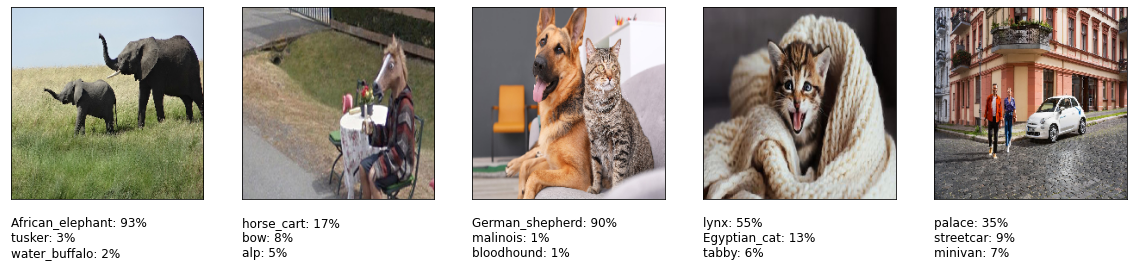

In [ ]:
from keras.applications import resnet

model = resnet.ResNet50(weights='imagenet')

batch = []
for x in raw_images:

    # preprocesamos
    x = resnet.preprocess_input(np.copy(x) * 255)
    
    # la agregamos a nuestro batch
    batch.append(x)

batch = np.array(batch)
preds = model.predict(batch)
texts = ['\n'.join([f"{name}: {int(score*100)}%" for _, name, score in dpred])
                    for dpred in resnet.decode_predictions(preds, top=3)]

images = [{'image': im, 'tag': tag} for im, tag in zip(raw_images, texts)]
show_images(images)    

El siguiente paso es obtener los mapas de características. Resnet generaba 2048 mapas en su última capa. Esta capa se llama *conv5_block3_add* y podemos acceder a ella con el método `get_layer`. Una vez tenemos una referencia a la capa podemos obtener su salida y su dimensión:



In [ ]:
model.get_layer('conv5_block3_add').output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_add')>

Ahora nos podemos construir una función de keras cuya entrada sea la entrada del modelo y nos dé como salida la salida de la capa *conv5_block3_add*:

In [ ]:
from keras import backend as K

get_feature_maps = K.function([model.input], [model.get_layer('conv5_block3_add').output])

Si llamamos a esta función y le pasamos como entrada la imagen de los elefantes nos debe devolver los mapas de características:

In [ ]:
get_feature_maps(batch)[0].shape

(5, 7, 7, 2048)

In [ ]:
batch[0:1].shape

(1, 224, 224, 3)

Como ejemplo vamos a mostrar el primero de ellos:

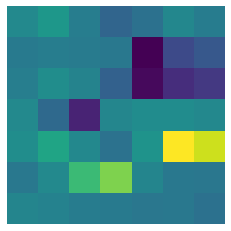

In [ ]:
plt.imshow(get_feature_maps(batch[0:1])[0][0,:,:,0])
plt.axis('off') #, cmap='PuBu_r')
plt.show()

Ahora que ya tengo los 2048 mapas de características, tenemos que ponderar cada uno de ellos usando los pesos de capa densa, pero tomando únicamente aquellos que corresponden con las categoría detectada. Para ello usamos el método `get_weights`. Este método nos debería dar una vector con 2048 posiciones. Uno peso por cada mapa de características:

In [ ]:
model.get_weights()[-2][:, preds.argmax()].shape

(2048,)

Ya tenemos todos los componentes necesarios. Ahora solo tenemos que multiplicar este último vector por nuestro array de mapas componente a componente y sumar los mapas ponderados. Esto nos dará el mapa de activación que estamos buscando:

In [ ]:
feature_maps = get_feature_maps(batch)[0]
heatmaps = []
for i in range(feature_maps.shape[0]):
    fm = feature_maps[i]
    pred = preds[i]
    heatmap = np.sum(fm * model.get_weights()[-2][:, pred.argmax()], axis=2)
    
    # normalizamos y eliminamos los valores menores a 0
    heatmap = np.clip(heatmap, 0, heatmap.max()) / heatmap.max()
    
    heatmaps.append(heatmap)


Y ahora ya podemos ver nuestros mapa de activaciones:

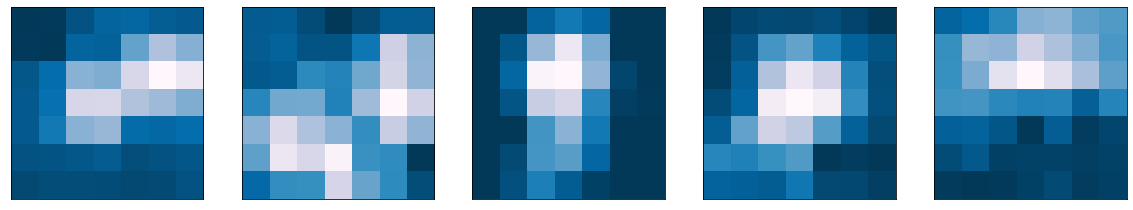

In [ ]:
images = [{'image': im, 'cmap': 'PuBu_r'} for im in heatmaps]
show_images(images)


Podemos superponer este heatmap a nuestra imagen con ayuda de openCV:

In [ ]:
heatmap.min(), heatmap.max(), heatmap.shape

(0.07255877, 1.0, (7, 7))

In [ ]:
heatmap.max()

1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


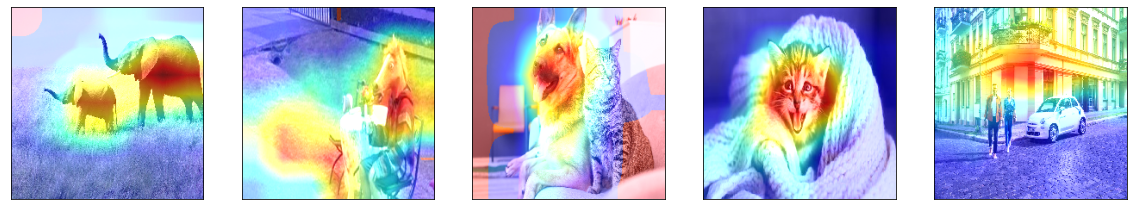

In [ ]:

superpuestas = []
for im, hm in zip(raw_images, heatmaps):

    # redimencionamos para que se ajuste al tamaño de la original
    heatmap = cv2.resize(hm, (im.shape[1], im.shape[0]))

    # convertimos a RGB
    heatmap = 1 - np.uint8(255 * heatmap)

    # generamos el heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # ponderamos y sumamos a la imagen original
    superimposed_img = heatmap * 0.6 + (im * 255) 

    superpuestas.append({'image': superimposed_img/255})
    
show_images(superpuestas)

En la siguiente imagen podemos ver otro ejemplos de mapas de calor, en escaso caso detectando perros en la imagen:

![dog cam](https://hdvirtual.us.es/discovirt/index.php/s/mbiDJfgMy3od2A7/preview)

Este método tiene un pequeño inconveniente. La red tiene que haber sido entrenada usando una GAP seguida de una capa densa. Si por ejemplo queremos aplicar este método en la red pre-entrenada VGG16 tendríamos que eliminar las últimas capas densas y agregar una AGP y una densa. Dado que esa capa densa no tiene los pesos aprendidos, tendremos que entrenar esas capas.

### Grad-CAM

En ["Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization." Ramprasaath R. Selvaraju et al., Cornell University Library, March 21, 2017](https://arxiv.org/abs/1610.02391) desarrollaron una generalización el método anterior en la que no era necesario re-entrenar.

La idea es muy simple, consiste en tomar el mapa de cartacerísticas de una capa convolucional que produce una imagen de entrada y ponderar cada mapa con los gradientes de la clase con respecto a ese canal. Lo único que vamos a cambiar es esa ponderación, que antes eran los pesos aprendidos, por los gradientes.

De nuevo, vamos a probar esta técnica usando una red preentrenada, pero esta vez vamos a usar la VGG16 que no tiene la AGP:

Como en el caso anterior leemos la imagen y la preprocesamos usando la función correspondiente de la vgg16:

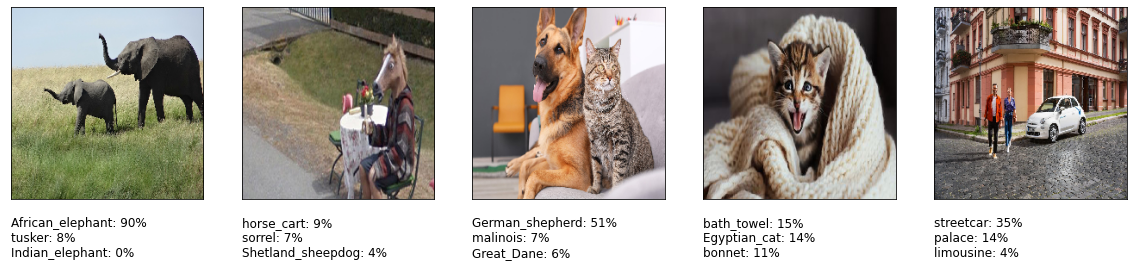

In [ ]:
from keras.applications import vgg16 

K.clear_session()
model = vgg16.VGG16(weights='imagenet')

batch = []
for x in raw_images:

    # preprocesamos
    x = vgg16.preprocess_input(np.copy(x) * 255)
    
    # la agregamos a nuestro batch
    batch.append(x)

batch = np.array(batch)
preds = model.predict(batch)
texts = ['\n'.join([f"{name}: {int(score*100)}%" for _, name, score in dpred])
                    for dpred in vgg16.decode_predictions(preds, top=3)]

images = [{'image': im, 'tag': tag} for im, tag in zip(raw_images, texts)]
show_images(images)    

En siguiente código lleva a cabo el método Grad-CAM:


In [ ]:
# Mapa de características de la capa `block5_conv3` 
# la última convolución de la red
last_conv_layer = model.get_layer('block5_pool')

superpuestas = []
heatmaps = []
for raw_im, im, pred in zip(raw_images, batch, preds):
    
    # Valor de salida para la predicción de mayor probabilidad
    class_output = model.output[:, np.argmax(pred)]

    # Calculamos el gradiente según según el error
    # producido en la clase con respecto
    # a la salida de la capa`block5_conv3`
    grads = K.gradients(class_output, last_conv_layer.output)[0]

    # Creamos un vector, donde cada entrada
    # sea la media de la intensidad de el gradiente sobre el mapa 
    # de características 
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Esta función nos permitirá acceder a los valores de las cantidades definidas
    get_outputs = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    pooled_grads_value, conv_layer_output_value = get_outputs([im.reshape((1,) + im.shape)])

    # Multiplicamos cada mapa de características por
    # la importancia de ese canal para la clasificación
    conv_layer_output_value *= pooled_grads_value

    # Obtenemos el heatmap aplicando la media
    heatmap = np.mean(conv_layer_output_value, axis=-1)

    # redimencionamos para que se ajuste al tamaño de la original
    heatmap = cv2.resize(hm, (im.shape[1], im.shape[0]))

    # aplicamos el método anterior para superponer el heatmap
    heatmap = 1 - np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.6 + (raw_im * 255) 

    
    
    dpred = vgg16.decode_predictions(np.array([pred]), top=3)[0]
    text = '\n'.join([f"{name}: {int(score*100)}%" for _, name, score in dpred])


    superpuestas.append({'image': superimposed_img/255, 'tag': text})

show_images(superpuestas)    

RuntimeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


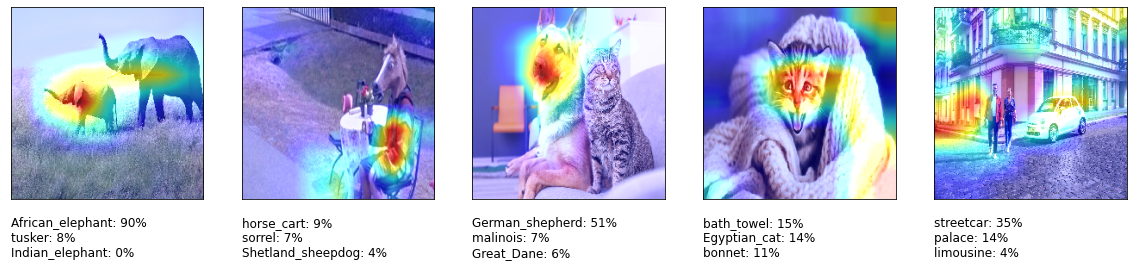

In [50]:


def crear_gram_heatmap(im, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.array([im]))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


superpuestas = []
heatmaps = []
for raw_im, im, pred in zip(raw_images, batch, preds):
    heatmap = crear_gram_heatmap(im, model, 'block5_pool', np.argmax(pred))
    
    # redimencionamos para que se ajuste al tamaño de la original
    heatmap = cv2.resize(heatmap, (im.shape[1], im.shape[0]))
    
    # aplicamos el método anterior para superponer el heatmap
    heatmap = 255 - np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.6 + (raw_im * 255) 

    
    
    dpred = vgg16.decode_predictions(np.array([pred]), top=3)[0]
    text = '\n'.join([f"{name}: {int(score*100)}%" for _, name, score in dpred])


    superpuestas.append({'image': superimposed_img/255, 'tag': text})

show_images(superpuestas)  

## Referencias
- [Deep Learning with Python](http://faculty.neu.edu.cn/yury/AAI/Textbook/Deep%20Learning%20with%20Python.pdf)

- [Visualization in Deep Learning](https://medium.com/multiple-views-visualization-research-explained/visualization-in-deep-learning-b29f0ec4f136)

- [Feature visualization](https://distill.pub/2017/feature-visualization/)

- [SmoothGrad: Removing noise adding noise](https://arxiv.org/pdf/1706.03825.pdf)

- [Machine Learning Interpretability](https://www.mdpi.com/2079-9292/8/8/832/pdf)

- [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf)

- [Global Average Pooling Layers for Object Localization](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/)

- [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks)

- [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf)

